In [103]:
#IMPORT RELEVANT LIBRARIES

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

# Modelling & Feature Selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

# Evaluation & Metrics
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score
)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

## 1. Data Overview

We begin by importing the data and exploring its structure. This includes:

- Listing available files
- Checking dataset dimensions
- Looking at basic sample rows

These steps help us understand what kind of information we're working with and verify the integrity of the loaded files.


In [104]:
train = pd.read_csv("/kaggle/input/GiveMeSomeCredit/cs-training.csv")
test = pd.read_csv("/kaggle/input/GiveMeSomeCredit/cs-test.csv")
data_excel = pd.read_excel("/kaggle/input/GiveMeSomeCredit/Data Dictionary.xls")
sample_data = pd.read_csv("/kaggle/input/GiveMeSomeCredit/sampleEntry.csv")


In [105]:
train_df = train.copy()
test_df = test.copy()

In [106]:
train_df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## 2. Initial Exploration and Missing Values

In this step, we:

- Display data types and shapes
- Identify missing values
- View summary statistics using `.describe()`

Understanding the nature and amount of missing values helps define our data cleaning strategy. We also explore target class imbalance.

In [107]:
print("====== SUMMARY =======")
print()
print(f"Training set size: {train_df.shape}")
print(f"Testing set size:  {test_df.shape}")
print()
print(f"All features in the training dataset: {', '.join(map(str, train_df.columns))}")
print(f"All features in the testing dataset: {', '.join(map(str, test_df.columns))}")
print()
print("---Training set survivability---")
print(f"Number of Applicants: {train_df.shape[0]}")
print(f"Number of Applicants with financial distress = {len(train_df[train_df['SeriousDlqin2yrs'] == 1])}")
print(f"Percentage of Applicants with financial distress = {len(train_df[train_df['SeriousDlqin2yrs'] == 1]) / train_df.shape[0] * 100} %")
print()
print("---Missing data [%]---")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])
print()
print("---Data types---")
print(train_df.info())
print()


====== SUMMARY =======

Training set size: (150000, 12)
Testing set size:  (101503, 12)

All features in the training dataset: Unnamed: 0, SeriousDlqin2yrs, RevolvingUtilizationOfUnsecuredLines, age, NumberOfTime30-59DaysPastDueNotWorse, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate, NumberRealEstateLoansOrLines, NumberOfTime60-89DaysPastDueNotWorse, NumberOfDependents
All features in the testing dataset: Unnamed: 0, SeriousDlqin2yrs, RevolvingUtilizationOfUnsecuredLines, age, NumberOfTime30-59DaysPastDueNotWorse, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate, NumberRealEstateLoansOrLines, NumberOfTime60-89DaysPastDueNotWorse, NumberOfDependents

---Training set survivability---
Number of Applicants: 150000
Number of Applicants with financial distress = 10026
Percentage of Applicants with financial distress = 6.683999999999999 %

---Missing data [%]---
MonthlyIncome         29731
NumberOfDependents     3924
dtype

DATA SUMMARY

In [108]:
print("---Statistical summary---")
round(train_df.describe(),2)

---Statistical summary---


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.00,150000.00,150000.00,150000.00,150000.00,150000.00,120269.00,150000.00,150000.00,150000.00,150000.00,146076.00
mean,75000.50,0.07,6.05,52.30,0.42,353.01,6670.22,8.45,0.27,1.02,0.24,0.76
std,43301.41,0.25,249.76,14.77,4.19,2037.82,14384.67,5.15,4.17,1.13,4.16,1.12
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,37500.75,0.00,0.03,41.00,0.00,0.18,3400.00,5.00,0.00,0.00,0.00,0.00
50%,75000.50,0.00,0.15,52.00,0.00,0.37,5400.00,8.00,0.00,1.00,0.00,0.00
75%,112500.25,0.00,0.56,63.00,0.00,0.87,8249.00,11.00,0.00,2.00,0.00,1.00
max,150000.00,1.00,50708.00,109.00,98.00,329664.00,3008750.00,58.00,98.00,54.00,98.00,20.00


## 3. Exploratory Data Analysis (EDA)

We use histograms, boxplots, and count plots to:

- Understand distributions of numeric features
- Identify potential outliers and skewness
- Analyze how features like age, income, and utilization vary
- Compare distributions across the target variable

This helps form intuition about which features might influence the target.

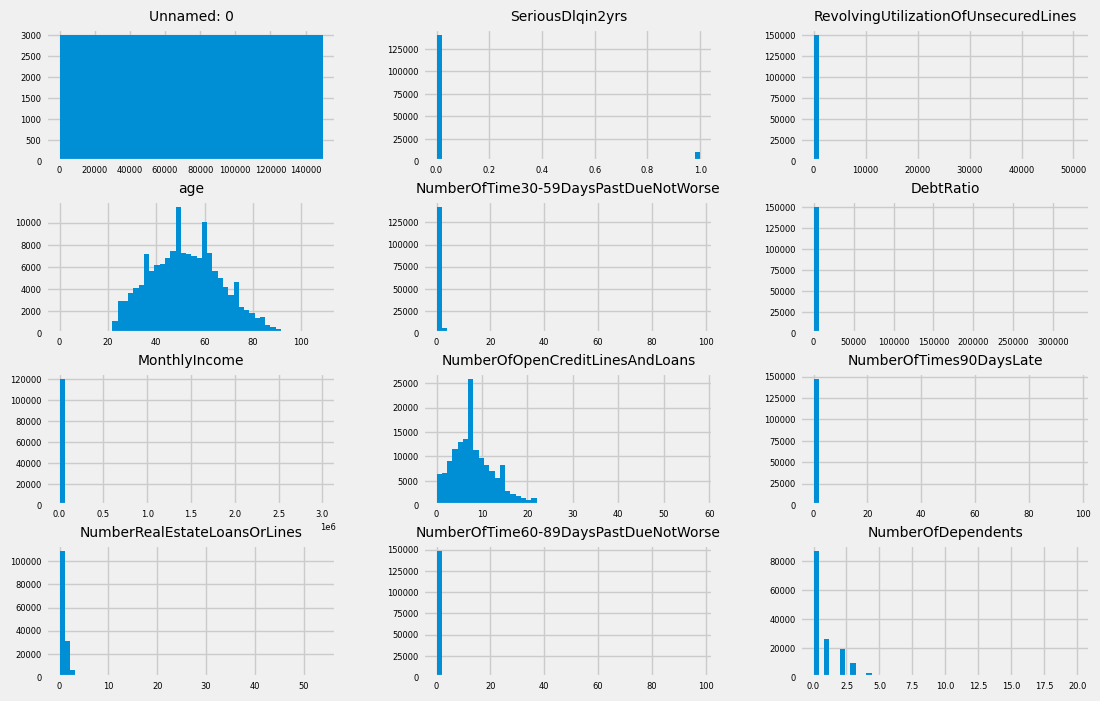

In [109]:
plt.rc('font',size=10)
plt.rc('axes',labelsize=10,titlesize=10)
plt.rc('legend',fontsize=8)
plt.rc('xtick',labelsize=6)
plt.rc('ytick',labelsize=6)

train_df.hist(bins=50,figsize=(12,8))
plt.show()

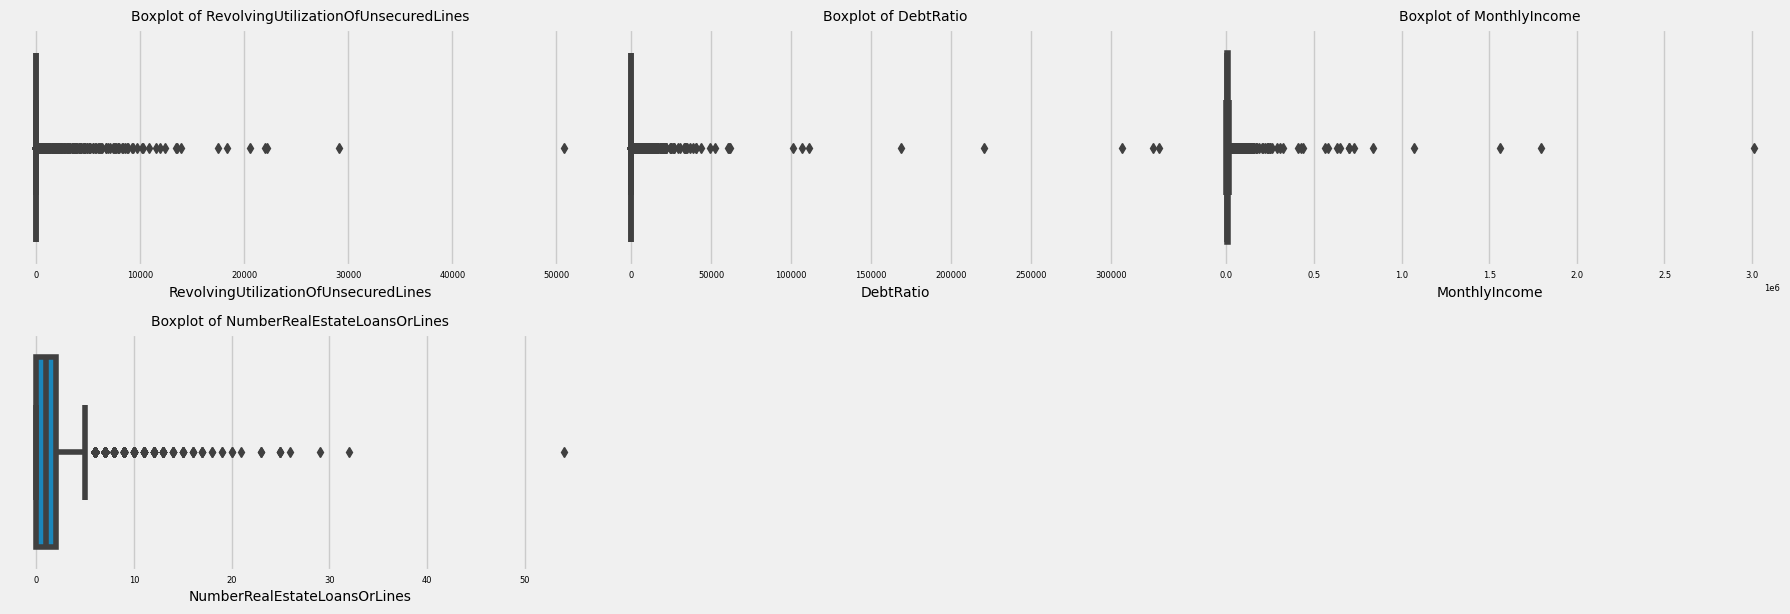

In [110]:
outliers_col = ['RevolvingUtilizationOfUnsecuredLines','DebtRatio','MonthlyIncome','NumberRealEstateLoansOrLines']
plt.figure(figsize=(18, 12)) # Set overall figure size
for i, col in enumerate(train_df[outliers_col], 1):
    plt.subplot(4, 3, i) # Create subplot in 4x3 grid
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

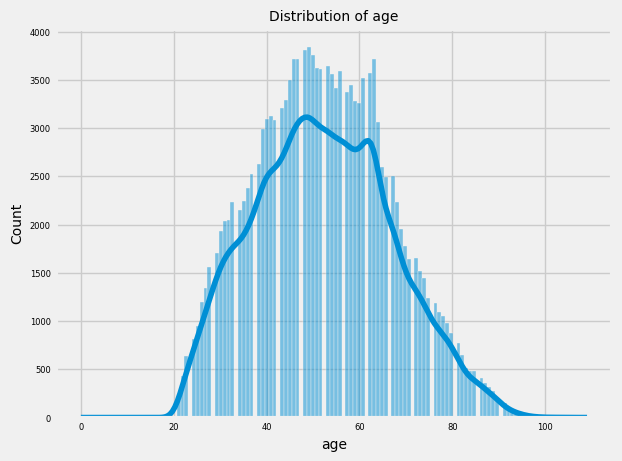

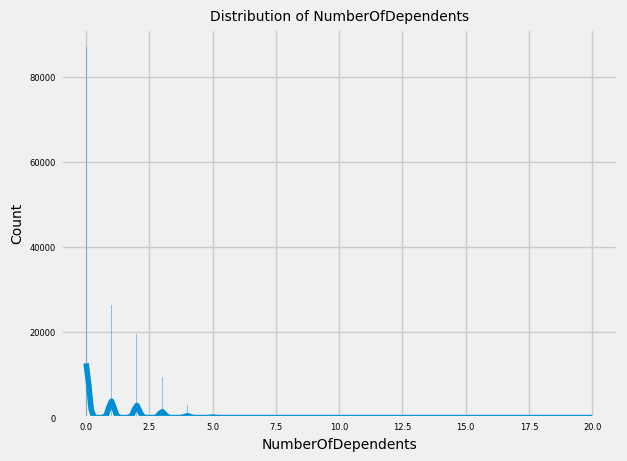

In [111]:
dist_col = ['age','NumberOfDependents']

for col in train_df[dist_col]:
    sns.histplot(train_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

NumberOfOpenCreditLinesAndLoans is skewed. Need to take log to get rid of skewness.

CORRELATION BETWEEN VARIABLES AND WITH TARGET VARIABLE

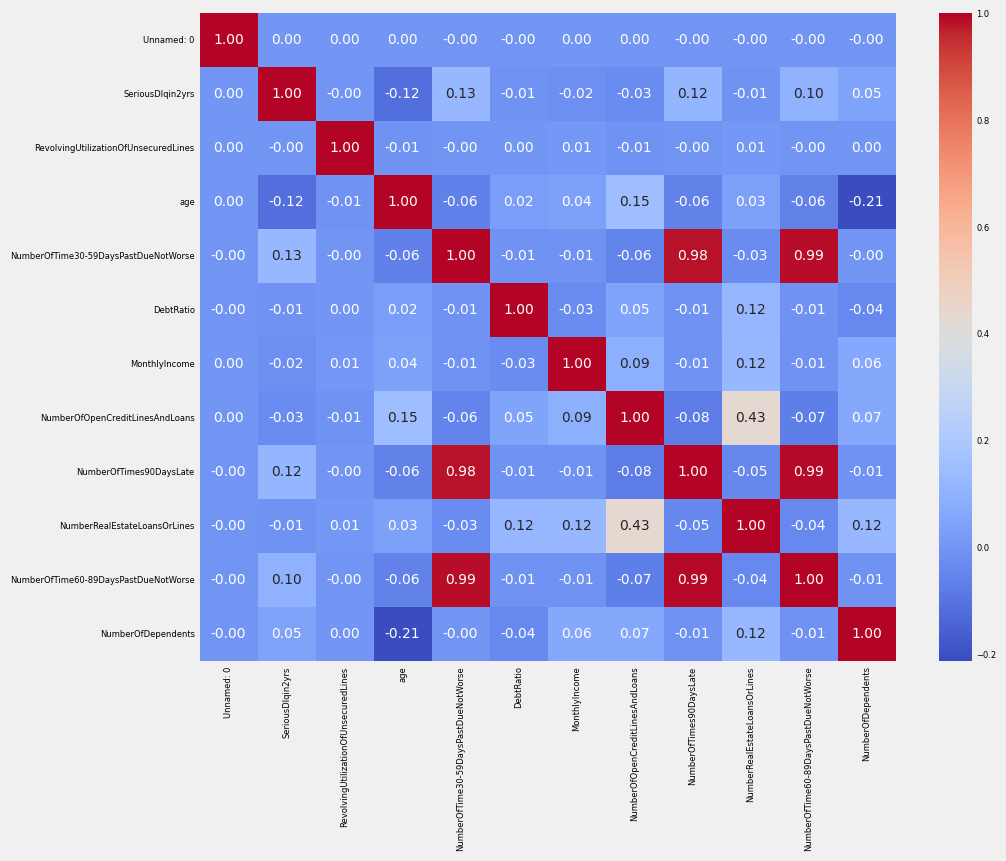

In [112]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

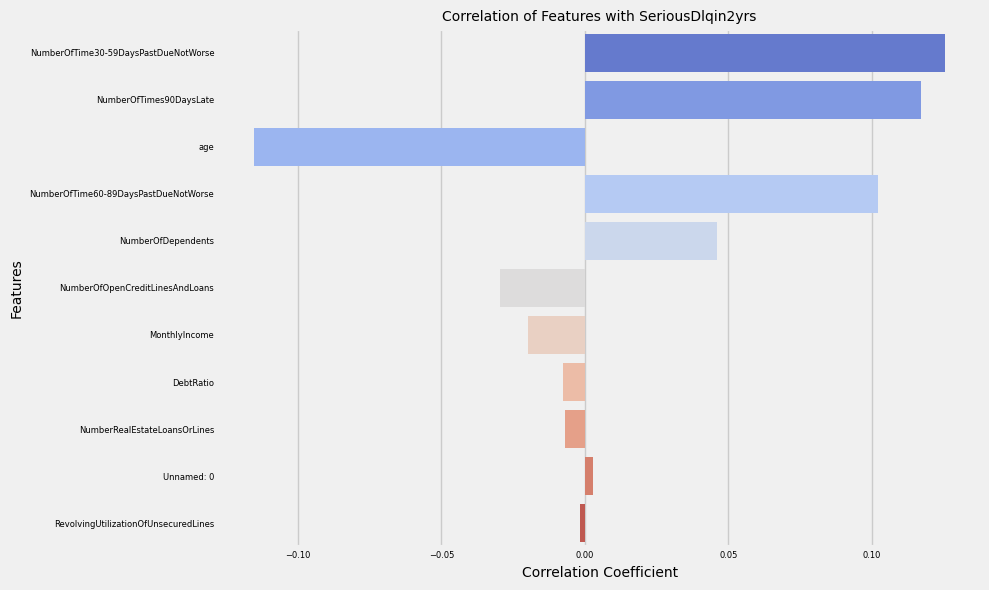

In [113]:
# Calculate correlation of each feature with SeriousDlqin2yrs
target_corr = train_df.corr()['SeriousDlqin2yrs']

# Sort correlations by absolute value (optional, for better visualization)
target_corr = target_corr.sort_values(key=abs, ascending=False).drop('SeriousDlqin2yrs')

plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")
plt.title("Correlation of Features with SeriousDlqin2yrs")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


## 4. Data Cleaning & Feature Engineering

Key steps:
- **Binning Age** into categorical groups
- **Imputing MonthlyIncome** using median by age group
- **Handling outliers** via IQR method for selected numerical features
- **Feature transformations** such as log-scaling and converting delinquency features into categories

These transformations help models perform better, especially tree-based ones.

In [114]:
def preprocess(df):

    df = df.copy()

    # Creating Age Groups and filling missing values of Monthly Income based on age group
    bins = [0,25,35,45,55,70,float('inf')]
    labels = [0,1,2,3,4,5]
    df['age_group'] = pd.cut(df['age'],bins=bins,labels=labels,include_lowest=True)

    median_income_by_age = df.groupby('age_group')['MonthlyIncome'].median()

    df['MonthlyIncome'] = df['MonthlyIncome'].replace(0, np.nan)
    df['MonthlyIncome'] = df.apply(lambda row:  median_income_by_age[row['age_group']] if pd.isnull(row['MonthlyIncome'])
                                          else row['MonthlyIncome'],axis=1)
    print("Remaining missing values in MonthlyIncome:", df['MonthlyIncome'].isnull().sum())

    # Handling outliers using IQR method 

    outliers_col = ['RevolvingUtilizationOfUnsecuredLines','DebtRatio','MonthlyIncome','NumberRealEstateLoansOrLines']

    for col in outliers_col:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    # Converting num columns into categories

    df['30-59_Due'] = df['NumberOfTime30-59DaysPastDueNotWorse'].apply(lambda x: 0 if x == 0 else 1 if x < 5 else 2)
    df['60-89_Due'] = df['NumberOfTime60-89DaysPastDueNotWorse'].apply(lambda x: 0 if x == 0 else 1 if x < 5 else 2)
    df['90+_Due'] = df['NumberOfTimes90DaysLate'].apply(lambda x: 0 if x == 0 else 1 if x < 5 else 2)
    
    df['NumberOfDependents'] = df['NumberOfDependents'].apply(lambda x: 0 if x == 0 else 1)
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(value=df['NumberOfDependents'].mode()[0])

    df['NumberOfOpenCreditLinesAndLoans'] = np.log1p(df['NumberOfOpenCreditLinesAndLoans'])
    
    df = df.drop(['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate','age'],axis=1)

    return df

In [115]:
preprocessed_train_df = preprocess(train_df)
preprocessed_test_df = preprocess(test_df)
preprocessed_train_df.info()

Remaining missing values in MonthlyIncome: 0
Remaining missing values in MonthlyIncome: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   Unnamed: 0                            150000 non-null  int64   
 1   SeriousDlqin2yrs                      150000 non-null  int64   
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64 
 3   DebtRatio                             150000 non-null  float64 
 4   MonthlyIncome                         150000 non-null  float64 
 5   NumberOfOpenCreditLinesAndLoans       150000 non-null  float64 
 6   NumberRealEstateLoansOrLines          150000 non-null  int64   
 7   NumberOfDependents                    150000 non-null  int64   
 8   age_group                             150000 non-null  category
 9   30-59_Due                          

## 5. Encoding Categorical Columns and Train-Test Split

We define categorical and numerical columns and use:

- **OneHotEncoding** for categorical features
- **StandardScaler** for numerical features

We then create a train-validation split to evaluate model performance before final test predictions.

In [116]:
cat = ['NumberRealEstateLoansOrLines','NumberOfDependents','age_group','30-59_Due','60-89_Due','90+_Due']
num = ['RevolvingUtilizationOfUnsecuredLines','DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans']

In [117]:
y = preprocessed_train_df['SeriousDlqin2yrs']
X = preprocessed_train_df.drop(['SeriousDlqin2yrs'],axis=1)

In [118]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=45)

## 6. Logistic Regression

We start with Logistic Regression as a baseline model:

- First without handling class imbalance
- Then with `class_weight='balanced'`

We evaluate precision, recall, and F1-score to understand how well the model identifies defaulters (target = 1).

In [119]:
cat_encoder = OneHotEncoder(handle_unknown="ignore",sparse_output=False)
scaler = StandardScaler()
logit = LogisticRegression(random_state=45)
col_transformer = make_column_transformer((cat_encoder,cat),(scaler,num),remainder='passthrough')

pipeline_basic = Pipeline([('col',col_transformer),('clf',logit)])

In [120]:
model = pipeline_basic.fit(X_train,y_train)

In [121]:
predict_val = model.predict(X_val)

In [122]:
precision_logit_unbalance = precision_score(y_val,predict_val)
print(f"Precision : {precision_logit_unbalance:.04f}")

recall_logit_unbalance = recall_score(y_val,predict_val)
print(f"Recall : {recall_logit_unbalance:.04f}")

f1_logit_unbalance = f1_score(y_val,predict_val)
print(f"F1 : {f1_logit_unbalance:.4f}")

Precision : 0.0000
Recall : 0.0000
F1 : 0.0000


In [123]:
np.unique(predict_val, return_counts=True)

(array([0]), array([30000]))

All predicted values in unbalanced target class is 0.

In [124]:
logit_bal = LogisticRegression(class_weight='balanced', random_state=45)
pipeline_logit = Pipeline([('col',col_transformer),('clf',logit_bal)])
model_logit_bal = pipeline_logit.fit(X_train,y_train)

In [125]:
pred_val_logit = model_logit_bal.predict(X_val)

In [126]:
precision_logit = precision_score(y_val,pred_val_logit)
print(f"Precision : {precision_logit:.4f}")

recall_logit = recall_score(y_val,pred_val_logit)
print(f"Recall : {recall_logit:.4f}")

f1_logit = f1_score(y_val,pred_val_logit)
print(f"F1 : {f1_logit:.4f}")

Precision : 0.1891
Recall : 0.7084
F1 : 0.2985


We will move ahead and train Random Forest and XGBoost as well. Both these models handle Non-linearity, Outliers and class imbalances better than Logistic
Regression.

## 7. Random Forest Classifier

We train a Random Forest classifier with `class_weight='balanced'` to handle target imbalance.

Tree-based models like Random Forest often perform better due to their ability to capture non-linear interactions.

We will also check impact of Threshold tuning on our model and we will compare model with different threshold.

In [127]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight = 'balanced',n_estimators=200,max_depth=6,min_samples_leaf=2,random_state=45)
pipeline_rf = Pipeline([('col',col_transformer),('clf',rfc)])

In [128]:
RFC_model = pipeline_rf.fit(X_train,y_train)

In [129]:
pred_val_rfc = RFC_model.predict(X_val)

In [130]:
precision_rfc = precision_score(y_val,pred_val_rfc)
print(f"Precision : {precision_rfc:.4f}")

recall_rfc = recall_score(y_val,pred_val_rfc)
print(f"Recall : {recall_rfc:.4f}")

f1_rfc = f1_score(y_val,pred_val_rfc)
print(f"F1 : {f1_rfc:.4f}")

Precision : 0.2202
Recall : 0.7225
F1 : 0.3376


By default the Threshold is 0.5 for classification. We will try different thresholds to check the impact on evaluation parameters.

In [131]:
y_prob = RFC_model.predict_proba(X_val)[:, 1]

# Threshold = 0.3
custom_thresh = 0.3
y_pred_thresh = (y_prob >= custom_thresh).astype(int)

P03 = precision_score(y_val, y_pred_thresh).round(4)
R03 = recall_score(y_val, y_pred_thresh).round(4)
F03 = f1_score(y_val, y_pred_thresh).round(4)

print(f"Precision: {P03}")
print(f"Recall: {R03}")
print(f"F1: {F03}")

Precision: 0.1424
Recall: 0.8889
F1: 0.2454


In [132]:
y_prob = RFC_model.predict_proba(X_val)[:, 1]

# Threshold = 0.4
custom_thresh = 0.4
y_pred_thresh = (y_prob >= custom_thresh).astype(int)

P04 = precision_score(y_val, y_pred_thresh).round(4)
R04 = recall_score(y_val, y_pred_thresh).round(4)
F04 = f1_score(y_val, y_pred_thresh).round(4)

print(f"Precision: {P04}")
print(f"Recall: {R04}")
print(f"F1: {F04}")

Precision: 0.157
Recall: 0.8592
F1: 0.2655


In [133]:
y_prob = RFC_model.predict_proba(X_val)[:, 1]

# Threshold = 0.7
custom_thresh = 0.7
y_pred_thresh = (y_prob >= custom_thresh).astype(int)

P07 = precision_score(y_val, y_pred_thresh).round(4)
R07 = recall_score(y_val, y_pred_thresh).round(4)
F07 = f1_score(y_val, y_pred_thresh).round(4)

print(f"Precision: {P07}")
print(f"Recall: {R07}")
print(f"F1: {F07}")

Precision: 0.3632
Recall: 0.5153
F1: 0.4261


Depending on business need, the threshold can be adjusted. For example, a threshold of 0.3 gives recall of 88.9%, ideal for risk-flagging, while 0.5 balances all metrics well.  
In typical lending scenarios, recall is prioritized to reduce risk. However, I’ve also evaluated threshold-tuned precision scores to allow for business-specific trade-offs, such as flagging high-risk customers for manual review vs. auto-rejection.  
Below is comparision of all and corresponding use cases.

In [134]:
RFC_comparision = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Threshold 0.3': [
        P03,R03,F03],
    'Threshold 0.5': [
        precision_rfc,recall_rfc,f1_rfc],
    'Threshold 0.7': [
        P07,R07,F07],
    'Use Cases':[
        "For Flaging risking Profiles",
        "Balanced System",
        "Auto Rejecting High Risk Profiles"]
})

RFC_comparision = RFC_comparision.round(4)

RFC_comparision


,Metric,Threshold 0.3,Threshold 0.5,Threshold 0.7,Use Cases
0,Precision,0.1424,0.2202,0.3632,For Flaging risking Profiles
1,Recall,0.8889,0.7225,0.5153,Balanced System
2,F1 Score,0.2454,0.3376,0.4261,Auto Rejecting High Risk Profiles


## 8. XGBoost Classifier

We use XGBoost — a gradient boosting algorithm that usually performs well on tabular datasets.

We set `scale_pos_weight` based on the class imbalance ratio to help the model focus on the minority class.

This model generally gives the best balance of recall and precision.

In [135]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    random_state=45
)

In [136]:
pipeline_xgb = Pipeline([('col',col_transformer),('clf',xgb_model)])
model_xgb = pipeline_xgb.fit(X_train,y_train)

In [137]:
predict_val_xgb = model_xgb.predict(X_val)

In [138]:

precision_xgb = precision_score(y_val, predict_val_xgb).round(4)
recall_xgb = recall_score(y_val, predict_val_xgb).round(4)
f1_xgb = f1_score(y_val, predict_val_xgb).round(4)

print(f"Precision: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"F1: {f1_xgb}")

Precision: 0.2153
Recall: 0.7572
F1: 0.3353


## 9. Model Comparison

We will compare all the models we trained and visualise it in form of table. We will then decide the model to use for final submission based on recall value.

In [139]:
Model_Comparision = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Logistic Regression (balanced)': [
        precision_logit,recall_logit,f1_logit],
    'Random Forest Classifier (balanced)': [
        precision_rfc,recall_rfc,f1_rfc],
    'XGBoost Classifier': [
        precision_xgb,recall_xgb,f1_xgb]
})

Model_Comparision = Model_Comparision.round(4)

Model_Comparision


,Metric,Logistic Regression (balanced),Random Forest Classifier (balanced),XGBoost Classifier
0,Precision,0.1891,0.2202,0.2153
1,Recall,0.7084,0.7225,0.7572
2,F1 Score,0.2985,0.3376,0.3353


We can clearly see that XGBoost Classifier gives us better recall than other models. It is 3% better than Random Forest and 5% better than Logisitic on the validation set.

In [140]:
test_prob = pipeline_xgb.predict_proba(preprocessed_test_df)[:, 1]

submission_df = pd.DataFrame({
    'Id': test_df['Unnamed: 0'],  
    'Probability': test_prob
})

submission_df.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
